In [1]:
import requests
import torch
from io import BytesIO
def get_s3_state_dict(s3_url):
    response = requests.get(s3_url, stream=True)
    bio = BytesIO(response.content)
    state_dict = torch.load(bio)
    return state_dict
#     model.load_state_dict(loaded["model"])

# s3_url = "https://uberduck-models.s3.us-west-1.amazonaws.com/radtts++ljs-dap.pt"
s3_url = "https://uberduck-models-us-west-2.s3.us-west-2.amazonaws.com/radtts%2B%2Bljs-dap.pt"
pretrained_dict = get_s3_state_dict(s3_url)['state_dict']


In [2]:
import os
os.chdir('/home/ray/default')
from uberduck_ml_dev.models.radtts import RADTTS
from uberduck_ml_dev.exec.train_radtts_with_ray import model_config, train_config, data_config


In [2]:

include_layers = []
ignore_layers_warmstart = []
# "warmstart"
model = RADTTS(
    **model_config,
)

if len(include_layers):
    pretrained_dict = {k: v for k, v in pretrained_dict.items()
                       if any(l in k for l in include_layers)}

if len(ignore_layers_warmstart):
    pretrained_dict = {k: v for k, v in pretrained_dict.items()
                       if all(l not in k for l in ignore_layers_warmstart)}

model_dict = model.state_dict()
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict, strict=False)
model = model.cuda()
# print("Warm started from {}".format(checkpoint_path))
# model.load_state_dict(state_dict['state_dict'])

Applying spectral norm to text encoder LSTM
Applying spectral norm to context encoder LSTM


/home/ray/default/uberduck_ml_dev/models/common.py:1523: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2349.)
  W = torch.qr(torch.FloatTensor(c, c).normal_())[0]
/home/ray/anaconda3/lib/python3.10/site-packages/torch/functional.py:1682: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced with
LU, pivots, info = torch.linalg.lu_factor_ex(A, compute_pivots) (Triggered 

In [3]:
from uberduck_ml_dev.exec.train_radtts_with_ray import get_ray_dataset


In [4]:
from uberduck_ml_dev.utils.utils import (
    to_gpu,
)
from uberduck_ml_dev.exec.train_radtts_with_ray import ray_df_to_batch_radtts, get_text

ray_dataset = get_ray_dataset()
# batch = ray_dataset.take(6)



2023-03-09 11:29:11,271	INFO worker.py:1360 -- Connecting to existing Ray cluster at address: 10.0.2.66:6379...
2023-03-09 11:29:11,278	INFO worker.py:1548 -- Connected to Ray cluster. View the dashboard at https://console.anyscale.com/api/v2/sessions/ses_ha6my3r3kl4mn9jdylcqnfutq1/services?redirect_to=dashboard 
2023-03-09 11:29:11,320	INFO packaging.py:330 -- Pushing file package 'gcs://_ray_pkg_f302303355eeefa4ea4ee3eb81ca4fb2.zip' (16.84MiB) to Ray cluster...
2023-03-09 11:29:11,558	INFO packaging.py:343 -- Successfully pushed file package 'gcs://_ray_pkg_f302303355eeefa4ea4ee3eb81ca4fb2.zip'.
(_get_read_tasks pid=4391, ip=10.0.26.49) 2023-03-09 11:29:13,174	WARNING file_meta_provider.py:162 -- Expanding 100 path(s). This may be a HIGH LATENCY operation on some cloud storage services. If the specified paths all point to files and never directories, try rerunning this read with `meta_provider=FastFileMetadataProvider()`.


In [5]:
batch = ray_dataset.take(1)
batch[0]['path']

2023-03-09 11:29:14,536	INFO bulk_executor.py:41 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(<lambda>)] -> AllToAllOperator[zip] -> AllToAllOperator[zip] -> AllToAllOperator[zip] -> TaskPoolMapOperator[MapBatches(<lambda>)]
MapBatches(<lambda>):   0%|          | 0/100 [00:00<?, ?it/s]

(autoscaler +11s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +11s) Removing 1 nodes of type worker-node-type-0 (idle).


MapBatches(<lambda>): 100%|██████████| 100/100 [00:03<00:00, 29.24it/s]
2023-03-09 11:29:18,119	INFO bulk_executor.py:41 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[read] -> TaskPoolMapOperator[MapBatches(<lambda>)]
read:   8%|▊         | 8/100 [00:00<00:11,  8.12it/s]

(autoscaler +16s) Removing 1 nodes of type worker-node-type-0 (idle).


MapBatches(<lambda>): 100%|██████████| 100/100 [00:00<00:00, 1235.40it/s]
2023-03-09 11:29:22,410	INFO bulk_executor.py:41 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(<lambda>)]
MapBatches(<lambda>): 100%|██████████| 100/100 [00:00<00:00, 2702.88it/s]
2023-03-09 11:29:22,588	INFO bulk_executor.py:41 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(<lambda>)]
MapBatches(<lambda>): 100%|██████████| 100/100 [00:00<00:00, 1282.69it/s]


's3://uberduck-datasets-dirty/lj_for_upload/lj_data/LJSpeech-1.1/wavs/LJ001-0001_22k_normalized.wav'

In [6]:
from tqdm import tqdm
# sample_text.shape[1]

In [7]:
batch_dict = ray_df_to_batch_radtts(next(ray_dataset.iter_batches(batch_size=1)))
batch_dict['audiopaths']

/home/ray/default/uberduck_ml_dev/exec/train_radtts_with_ray.py:457: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  audio = torch.FloatTensor(wav_data)


[['s3://uberduck-datasets-dirty/lj_for_upload/lj_data/LJSpeech-1.1/wavs/LJ001-0001_22k_normalized.wav']]

In [8]:
batch_iterator = ray_dataset.iter_batches(batch_size=1)

In [9]:
for i in tqdm(range(100)):
    batch_dict = ray_df_to_batch_radtts(next(batch_iterator))
    print(batch_dict['audiopaths'][0][0].split('wavs/')[-1])
    if batch_dict['audiopaths'][0][0].split('wavs/')[-1] == "LJ001-0005_22k_normalized.wav":
        print(i)
        break
#     if batch_dict['text'].shape[1] == sample_text.shape[1]:
#         print(i)
#         if all(batch_dict['text'] == sample_text):
#             print(i)
#             break

  0%|          | 0/100 [00:00<?, ?it/s]

LJ001-0001_22k_normalized.wav


  1%|          | 1/100 [00:00<00:36,  2.70it/s]

(autoscaler +22s) Removing 1 nodes of type worker-node-type-0 (idle).
LJ001-0002_22k_normalized.wav


  2%|▏         | 2/100 [00:02<02:42,  1.66s/it]

LJ001-0003_22k_normalized.wav


  3%|▎         | 3/100 [00:04<02:31,  1.56s/it]

LJ001-0004_22k_normalized.wav


  4%|▍         | 4/100 [00:06<02:49,  1.77s/it]

(autoscaler +27s) Removing 1 nodes of type worker-node-type-0 (idle).
LJ001-0005_22k_normalized.wav
4


  4%|▍         | 4/100 [00:08<03:16,  2.04s/it]


In [41]:
binarize = False

mel = to_gpu(batch_dict['mel'])
speaker_ids = to_gpu(batch_dict['speaker_ids'])
attn_prior = to_gpu(batch_dict['attn_prior'])
f0 = to_gpu(batch_dict['f0'])
voiced_mask = to_gpu(batch_dict['voiced_mask'])
p_voiced = to_gpu(batch_dict['p_voiced'])
text = to_gpu(batch_dict['text'])
in_lens = to_gpu(batch_dict['input_lengths'])
out_lens = to_gpu(batch_dict['output_lengths'])
energy_avg = to_gpu(batch_dict['energy_avg'])

torch.manual_seed(1234)
with torch.no_grad():
    outputs = model(
                mel, speaker_ids, text, in_lens, out_lens,
                binarize_attention=binarize, attn_prior=attn_prior,
                f0=f0, energy_avg=energy_avg,
                voiced_mask=voiced_mask, p_voiced=p_voiced)

/home/ray/anaconda3/lib/python3.10/site-packages/torch/nn/modules/rnn.py:777: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, batch_sizes, hx, self._flat_weights, self.bias,


<Axes: >

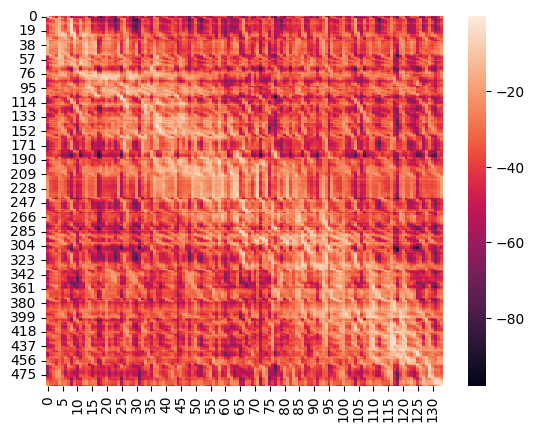

In [38]:
sns.heatmap(outputs['attn_logprob'][0].cpu()[0])

In [47]:
from uberduck_ml_dev.losses import RADTTSLoss

In [53]:
sigma = train_config['sigma']
criterion = RADTTSLoss(
    sigma,
    model_config['n_group_size'],
    model_config['dur_model_config'],
    model_config['f0_model_config'],
    model_config['energy_model_config'],
    vpred_model_config=model_config['v_model_config'],
    loss_weights=train_config['loss_weights']
)

In [54]:
loss_outputs = criterion(outputs, in_lens, out_lens)

In [55]:
loss_outputs

{'loss_mel': (tensor(-1.6143, device='cuda:0'), 1.0),
 'loss_prior_mel': (tensor(0.6858, device='cuda:0'), 0.0),
 'loss_ctc': (tensor(10.0768, device='cuda:0'), 0.1)}

(autoscaler +1h36m9s) Failed to launch 1 node(s) of type worker-node-type-1. (VcpuLimitExceeded): You have requested more vCPU capacity than your current vCPU limit of 300 allows for the instance bucket that the specified instance type belongs to. Please visit http://aws.amazon.com/contact-us/ec2-request to request an adjustment to this limit.
(autoscaler +1h36m14s) Failed to launch 1 node(s) of type worker-node-type-1. (VcpuLimitExceeded): You have requested more vCPU capacity than your current vCPU limit of 300 allows for the instance bucket that the specified instance type belongs to. Please visit http://aws.amazon.com/contact-us/ec2-request to request an adjustment to this limit.
(autoscaler +1h36m20s) Failed to launch 1 node(s) of type worker-node-type-1. (VcpuLimitExceeded): You have requested more vCPU capacity than your current vCPU limit of 300 allows for the instance bucket that the specified instance type belongs to. Please visit http://aws.amazon.com/contact-us/ec2-request 

In [11]:
all(batch_dict['text'][0] == torch.tensor([  8,  94,  82,  79,   8, 147, 156, 180, 131, 156, 169, 110, 156,   8,
         89,  80,   8, 155, 178, 180, 110, 125, 110, 154,   8, 155, 131, 170,
        110, 154,   8, 154, 131, 170, 134, 183,   8,  83,  88,   8,  94,  82,
         79,   8, 155, 146, 127, 110, 154,   8,  89,  80,   8,  94,  82,  79,
          8, 141, 145, 141, 170, 150, 156, 171,   8, 168, 131, 156, 126, 134,
        149,   8, 155, 139,   8, 152, 111, 168, 170, 154, 149,   8,  76,  79,
          8, 153, 110, 156, 168, 146, 127, 134, 127,   8,  75,  93,   8,  94,
         82,  79,   8, 147, 156, 180, 131, 156, 169, 110, 156,   8,  89,  80,
          8,  94,  82,  79,   8, 103, 167, 170,   8,  89,  80,   8,  90,  92,
         83,  88,  94,  83,  88,  81,   4,   8]))

True

In [12]:
batch_dict.keys()

dict_keys(['mel', 'speaker_ids', 'text', 'input_lengths', 'output_lengths', 'audiopaths', 'attn_prior', 'f0', 'p_voiced', 'voiced_mask', 'energy_avg'])

In [24]:
# batch_dict['attn_prior'][0]
batch_dict['mel'][0]

tensor([[-1.1292, -0.8412, -0.3980,  ..., -0.8837, -0.8618, -0.7008],
        [-0.6186, -0.1970,  0.3030,  ..., -0.5665, -0.7870, -0.7083],
        [-0.6805,  0.0632,  0.5776,  ..., -0.6166, -0.5768, -0.5554],
        ...,
        [-1.7184, -0.1063,  0.5124,  ..., -1.6268, -1.4351, -1.4667],
        [-1.5186, -0.1120,  0.5166,  ..., -1.7884, -1.7738, -1.8844],
        [-1.5388, -0.3436,  0.2592,  ..., -1.7224, -1.8726, -1.9239]])

(autoscaler +25m45s) Removing 1 nodes of type worker-node-type-0 (idle).
(autoscaler +25m50s) Removing 1 nodes of type worker-node-type-0 (idle).
(autoscaler +25m55s) Removing 1 nodes of type worker-node-type-0 (idle).
(autoscaler +26m0s) Removing 1 nodes of type worker-node-type-0 (idle).
(autoscaler +26m5s) Removing 1 nodes of type worker-node-type-0 (idle).
(autoscaler +26m10s) Removing 1 nodes of type worker-node-type-0 (idle).
(autoscaler +26m15s) Removing 1 nodes of type worker-node-type-0 (idle).
(autoscaler +26m20s) Removing 1 nodes of type worker-node-type-0 (idle).
(autoscaler +26m25s) Removing 1 nodes of type worker-node-type-0 (idle).
(autoscaler +26m30s) Removing 1 nodes of type worker-node-type-1 (idle).
(autoscaler +26m30s) Removing 1 nodes of type worker-node-type-0 (idle).
(autoscaler +26m35s) Removing 1 nodes of type worker-node-type-1 (idle).
(autoscaler +26m35s) Removing 1 nodes of type worker-node-type-0 (idle).
(autoscaler +26m40s) Removing 1 nodes of type worker-

In [57]:
# import seaborn as sns
# %matplotlib inline
# sns.heatmap(batch_dict['attn_prior'][0])
# # sns.heatmap(batch_dict['mel'][0])

In [72]:
audio_norm.shape

torch.Size([1, 101376])

In [25]:
from uberduck_ml_dev.models.common import get_mel
from scipy.io.wavfile import read
import numpy as np
import torch

from uberduck_ml_dev.data.audio_processing import TacotronSTFT
stft = TacotronSTFT(
    filter_length=data_config['filter_length'],
    hop_length=data_config['hop_length'],
    win_length=data_config['win_length'],
    sampling_rate=22050,
    n_mel_channels=data_config['n_mel_channels'],
    mel_fmin=data_config['mel_fmin'],
    mel_fmax=data_config['mel_fmax'],
)

audio = read('crust.wav')[1]
max_wav_value = 32768
# audio_norm = (32768 - 1) * (audio / (np.abs(audio).max()))
# audio_norm = (32768 - 1) * audio / (np.abs(audio).max())
audio_norm = audio / (np.abs(audio).max()*2)
audio_norm = audio_norm / 32768

# audio_norm = audio


In [26]:
(32768 - 1)

32767

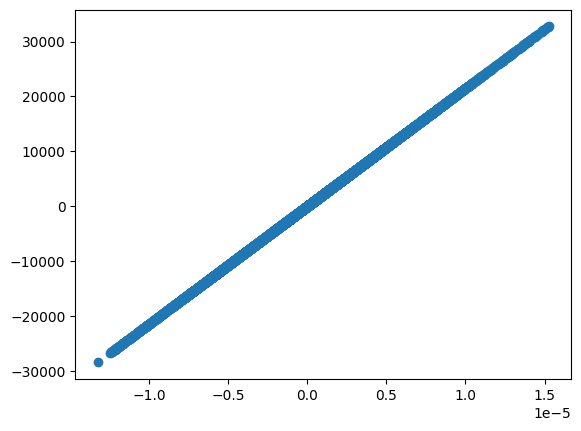

In [27]:
import matplotlib.pyplot as plt
plt.scatter(audio_norm, audio)

In [28]:
audio_norm = torch.FloatTensor(audio_norm)
audio_norm = audio_norm.unsqueeze(0)
audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
melspec = stft.mel_spectrogram(audio_norm)
mel = torch.squeeze(melspec, 0)

In [29]:
# mel = get_mel(torch.FloatTensor(audio_norm),32768, stft)

<Axes: >

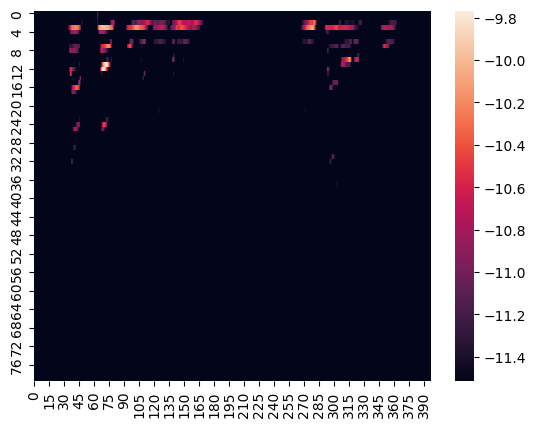

In [30]:




# mel = get_mel(torch.FloatTensor(audio_norm),32768, stft)

%matplotlib inline
import seaborn as sns
sns.heatmap(mel)

In [17]:
audio_norm = audio_norm.unsqueeze(0)
audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
melspec = stft.mel_spectrogram(audio_norm)
melspec = torch.squeeze(melspec, 0)

<Axes: >

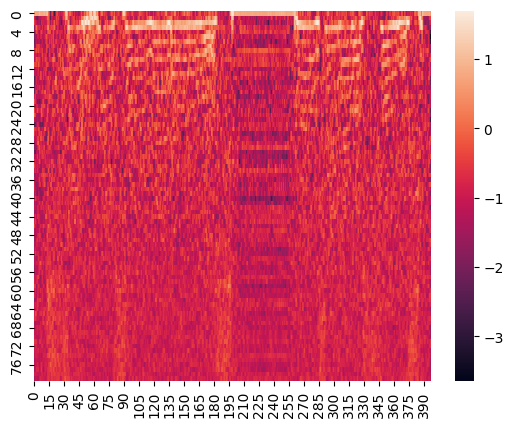

In [18]:
%matplotlib inline
import seaborn as sns
sns.heatmap(melspec)

In [ ]:
%matplotlib inline
import seaborn as sns
sns.heatmap(mel[:,:])

In [11]:
batch_dict['audiopaths'][0][0].split('wavs/')[-1]

'LJ001-0001_22k_normalized.wav'

In [ ]:
binarize = False

mel = to_gpu(batch_dict['mel'])
speaker_ids = to_gpu(batch_dict['speaker_ids'])
attn_prior = to_gpu(batch_dict['attn_prior'])
f0 = to_gpu(batch_dict['f0'])
voiced_mask = to_gpu(batch_dict['voiced_mask'])
p_voiced = to_gpu(batch_dict['p_voiced'])
text = to_gpu(batch_dict['text'])
in_lens = to_gpu(batch_dict['input_lengths'])
out_lens = to_gpu(batch_dict['output_lengths'])
energy_avg = to_gpu(batch_dict['energy_avg'])

with torch.no_grad():
    outputs = model(
                mel, speaker_ids, text, in_lens, out_lens,
                binarize_attention=binarize, attn_prior=attn_prior,
                f0=f0, energy_avg=energy_avg,
                voiced_mask=voiced_mask, p_voiced=p_voiced)

In [20]:
sample_text = torch.tensor([[  8,  75,  88,  78,   8,  97,  75,  93,   8,  95,  93,  79,  78,   8,
         128, 131, 167,   8,  97,  83,  94,  82,   8, 180, 131, 167, 149,   8,
         154, 146, 170, 110, 154,   8, 180, 132, 167, 149, 139, 169, 110, 156,
           8, 115, 154,   8, 171, 167, 178,   8,  94,  82,  79,   8,  93,  83,
          98,  94,  79,  79,  88,  94,  82,   8,  75,  88,  78,   8, 168, 131,
         180, 110, 156, 170, 150, 156, 171,   8, 168, 131, 156, 126, 134, 149,
         183,   3,   8,  75,  88,  78,   8, 147, 156, 127, 150, 127,   8,  83,
          88,  94,  89,   8,  94,  82,  79,   8,  79,  83,  81,  82,  94,  79,
          79,  88,  94,  82,   4,   8]])

In [29]:
get_text('your mom')

tensor([  8,  99,  89,  95,  92,   8, 155, 103, 155,   8])

In [30]:
get_text('your mom is a lovely woman.')

tensor([  8,  99,  89,  95,  92,   8, 155, 103, 155,   8,  83,  93,   8,  75,
          8, 154, 111, 180, 154, 149,   8, 181, 174, 155, 110, 156,   4,   8])